# Human proteins Network



In [1]:
import csv
import scipy 
from scipy import sparse
import scipy.sparse.linalg
import numpy as np
import matplotlib.pyplot as plt

The following lines of code are used to import the adjacency matrix of the human proteins network. 
Then, a scipy sparse matrix is created to store such matrix.

### Import Adjacency matrix

In [3]:
class Network():
    
    def __init__(self,filename):
        self.filename = filename
        self.import_Network()
        
    def import_Network(self):

        list_rows=[]

        with open(self.filename) as tsvfile:
            reader = csv.DictReader(tsvfile, dialect='excel-tab')
            for row in reader:
                s = row['% asym unweighted'].split()
                list_rows.append(list(map(int, s)) )
    
        vals = np.array(list_rows)

        self.row = vals[:,0]
        self.col = vals[:,1]
        self.data = np.ones(vals.shape[0])
        self.num_vertices = int(np.max(self.col))+1
        self.num_edges = int(np.sum(self.data))
        
        
        self.adjacency = scipy.sparse.csr_matrix( (self.data, (self.row,self.col)), 
                                                 shape = (self.num_vertices,self.num_vertices))
        self.set_laplacian_matrix()
        
        
    def set_laplacian_matrix(self):
        out_degree = self.get_outdegree()
        
        self.laplacian = scipy.sparse.lil_matrix((self.num_vertices,self.num_vertices))
        self.laplacian.setdiag(np.array(out_degree).flatten())
        self.laplacian = self.laplacian - scipy.sparse.lil_matrix(self.adjacency)
        self.laplacian = scipy.sparse.csr_matrix(self.laplacian)        
        
        
    def get_indegree(self):
        degs = self.adjacency.sum(axis = 0)
        return degs.flatten()
    
    def get_outdegree(self):
        degs = self.adjacency.sum(axis = 1)
        return degs.flatten()
    

net = Network('out.maayan-figeys')


## NetworkX

We can also define the graph using the NetworkX package.

In [4]:
import networkx as nx

In [5]:
G = nx.from_scipy_sparse_matrix(net.adjacency, create_using = nx.DiGraph())

# Macroscale properties

**13/03/2020** 


## 1. Shortest paths

In the former notebook, we evaluated the centrality of the nodes, using different measures. Now, we will evaluate the *global* centrality of the network. We will calculate different global properties of the network:

### Mean shortest paths
The average shortest path length is

$$
a = \sum_{s,t \in V} \frac{d(s,t)}{n(n-1)}
$$

where $V$ is the set of nodes in $G$, $d(s,t)$ is the shortest path from $s$ to $t$ and $n$ is the number of nodes in the graph.

In [6]:
nx.average_shortest_path_length(G)

NetworkXError: Graph is not weakly connected.

We get an error because the graph is not weakly connected (there are disconnected components).

In [7]:
print('Is the graph weakly connected?', nx.is_weakly_connected(G))

print('Number of connected components in G: ', nx.number_weakly_connected_components(G))

print('length of connected components', [len(c) for c in sorted(nx.weakly_connected_components(G), key=len, reverse=True)])

Is the graph weakly connected? False
Number of connected components in G:  10
length of connected components [2217, 4, 3, 3, 3, 3, 2, 2, 2, 1]


We can see that there is one large connected component (of 2217 vertices) and many very small connected components (of 1-4 vertices). We will now get the subgraph of the largest connected component and work with it.

In [8]:
largest_cc = max(nx.weakly_connected_components(G), key=len)
G_con = G.subgraph(largest_cc)

Now we can calculate the mean shortest path length

In [9]:
print('Mean shortest path lenght: ', nx.average_shortest_path_length(G_con))

Mean shortest path lenght:  0.018096339574896314


### Eccentricity

The eccentricity of a node v is the maximum distance from v to all other nodes in G. It is a *local* property of the nodes, that will be used to calculate ther global properties such as the diameter of the graph.

We draw the graph with the size of the nodes being its eccentricity.

In [10]:
ecc = nx.eccentricity(G_con)

NetworkXError: Found infinite path length because the digraph is not strongly connected

Again, we get errors because the graph is only weakly connected but not strongly connected. 

In [11]:
largest_cc = max(nx.strongly_connected_components(G), key=len)
G_Scon = G.subgraph(largest_cc)

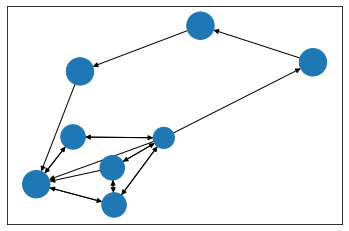

In [12]:
ecc = nx.eccentricity(G_Scon)

nx.draw_networkx(G_Scon,pos = nx.spring_layout(G_Scon), with_labels=False, node_size=[v*150 for v in ecc.values()])
plt.show()

We have plotted the largest strongly connected component, and all the eccentricity vales are of similar size. However, we note that the number of nodes is very very small compared to the total number of nodes.

### Radius

The radius is the minimum eccentricity.

In [13]:
print('Radius: ', nx.radius(G_Scon))

Radius:  3


### Center

The center is the set of nodes with eccentricity equal to radius.

In [14]:
print('The largest strongly connected component has center: ', nx.center(G_Scon)[0])

The largest strongly connected component has center:  48


### Diameter

The diameter is the maximum eccentricity.


In [15]:
print('The largest strongly connected component has diameter: ', nx.diameter(G_Scon))

The largest strongly connected component has diameter:  5


### Periphery

The periphery is the set of nodes with eccentricity equal to the diameter.

In [16]:
print('Peripherial nodes: ', nx.periphery(G_Scon))

Peripherial nodes:  [227, 296, 145, 538]


### Barycenter

The barycenter of a connected graph G is the subgraph induced by the set of nodes $v$ minimizing the objective function

$$
\sum_{u \in V(G)} d(u,v),
$$
where $V(G)$ is the set of nodes of the graph $G$.

In [17]:
print('The largest strongly connected component has barycenter: ',nx.barycenter(G_Scon)[0])

The largest strongly connected component has barycenter:  48


Notice that, in this case, the barycenter is a subgraph of $G$ consisting on a single node, which is the 48 one. 

## 2. Clustering

Now we will look at clustering properties of the network.

Remember the definition of the clustering coefficient of a node:

### Clustering coefficient of a node

$$
C_i = \frac{2\cdot E_i}{k_i(k_i-1)}
$$

where $E_i$ is the number of triangles of node $i$, and $k_i(k_i-1)$ represents the total number of triangles that the node could possibly have, being $k_i$ the node's degree. 

With this deffinition we can define the *global* clustering coefficient of the network.

### Clustering of the network

$$
C = \frac{1}{N} \sum_{i=1}^N C_i,
$$
where $N$ is the total number of nodes of the graph. Notice that it is the average clustering coefficient of all nodes.

In [18]:
print('Average clustering coefficient:', nx.average_clustering(G))

Average clustering coefficient: 0.022991199720053465


We can also inspect the clustering coefficient of a node as a function of the degree of such nodes.

In [19]:
clus = nx.clustering(G)
deg = dict(G.degree())

In [20]:
idx = np.argsort(list(deg.values()))

deg_vals = np.array(list(deg.values()))[idx]
clus_vals = np.array(list(clus.values()))[idx]

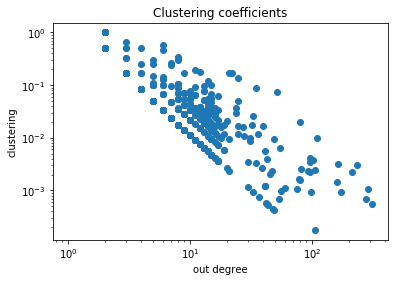

In [21]:
plt.plot(deg_vals, clus_vals, 'o')
plt.xscale('log')
plt.yscale('log')
plt.title("Clustering coefficients")
plt.xlabel('out degree')
plt.ylabel('clustering')
plt.show()

We observe some descreasing tendency. This happens because as the number of connection increases, it becomes more unlikely that the neighbours of a node are also connected. For this reason, we expect the clustering coefficient to decrease with the degree of the node. 

Now we will perform a linear fil to observe this trend

In [22]:
idx = clus_vals*deg_vals>0
coef = np.polyfit(np.log10(deg_vals[idx]),np.log10(clus_vals[idx]),1)
poly1d_fn = np.poly1d(coef) 

print('Slope of linear fit: ', coef[0])

Slope of linear fit:  -1.4185448157733733


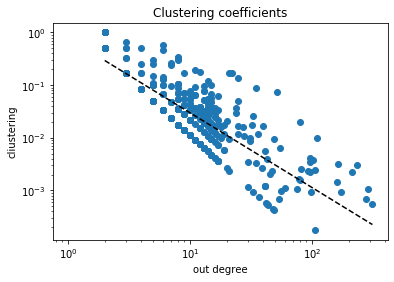

In [23]:
plt.plot(deg_vals, clus_vals, 'o')
plt.plot(deg_vals[idx], np.power(10,poly1d_fn(np.log10(deg_vals[idx]))), '--k')
plt.xscale('log')
plt.yscale('log')
plt.title("Clustering coefficients")
plt.xlabel('out degree')
plt.ylabel('cliustering')
plt.show()

We observe that the slope of the linear fit is approximately -1.4.

### Newman Clustering Coefficient


It is also known as the transitivity index of the network. It is the fraction of all possible triangles present in G. Possible triangles are identified by the number of “triads” (two edges with a shared vertex).

In [24]:
print('The Newman clustering coefficient is: ', nx.transitivity(G))

The Newman clustering coefficient is:  0.0015705864234240004


We observe that it is smaller than the clustering coefficient, but of the same order. The clustering coefficient quantifies how clustered is the network locally, while the Newman clustering coefficient quantifies how clustered is the network as a whole.

## 3. Degree Distribution

We will compute $P(k)$, that is, the probability that a randomly selected node has degree $k$. It is a measure in the spread the number of links the nodes have. 

In [25]:
degree_sequence = sorted([d for n, d in G.degree()], reverse=True) 

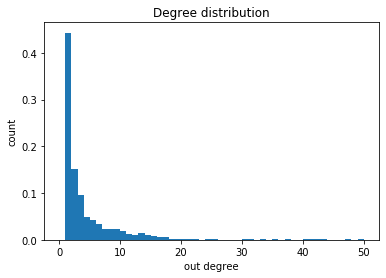

In [26]:
plt.hist(degree_sequence, bins=50, density=True, range=(0,50))
plt.title("Degree distribution")
plt.xlabel('out degree')
plt.ylabel('count')
plt.show()

We can see that with this histogram it is very hard to see the actual distribution of $P(k)$.

We observe that there are a lot of nodes with zero degree, and then the number decreases to zero. 

We want to see if the decrease to zero is exponential or if it follows a power low.

First of all, we plot the same histogram using a log-log scale.

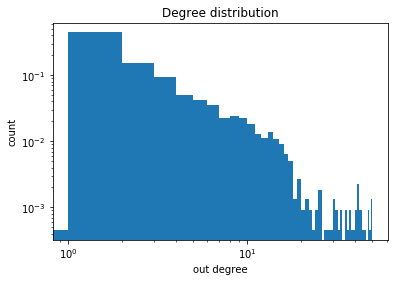

In [27]:
hist = plt.hist(degree_sequence, bins=50, density=True, range=(0,50))
plt.xscale('log')
plt.yscale('log')
plt.title("Degree distribution")
plt.xlabel('out degree')
plt.ylabel('count')
plt.show()

We observe that the decrease resembles a power low.

In order to see it better, we plot the degree distribution with points instead of a histogram

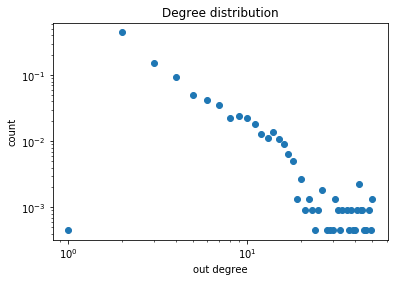

In [28]:
plt.plot(hist[1][1:],hist[0], 'o')
plt.xscale('log')
plt.yscale('log')
plt.title("Degree distribution")
plt.xlabel('out degree')
plt.ylabel('count')
plt.show()

We observe that more or less until degree 11, the distribution decays following a power low. For degrees larger than 11, there are very few nodes with such large degree, and therefore the probabilty of having such degree stabilizes. Now we will perform a linear fit of the first part of the plot.

In [32]:
coef = np.polyfit(np.log10(hist[1][2:26]),np.log10(hist[0][1:25]),1)
poly1d_fn = np.poly1d(coef) 

print('Slope of linear fit: ', coef[0])

Slope of linear fit:  -2.422838637957744


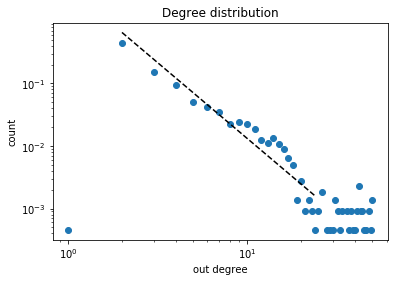

In [33]:
plt.plot(hist[1][1:],hist[0], 'o')
plt.plot(hist[1][2:25], np.power(10,poly1d_fn(np.log10(hist[1][2:25]))), '--k')
plt.xscale('log')
plt.yscale('log')
plt.title("Degree distribution")
plt.xlabel('out degree')
plt.ylabel('count')
plt.show()

The slope of the linear fit if of around -2.3.

Another way to calculate $\gamma$ is by looking at the cumulative distribution function (cdf) of the degree, instead of the density distribution. The cdf is more stable in the sense that it preserves better the power low behaviour for large degrees. Therefore, it may be easier to estimate $\gamma$ using the cdf. We will compare the value of $\gamma$ using both methods.  


Cumulative distribution function of $P(k)$:

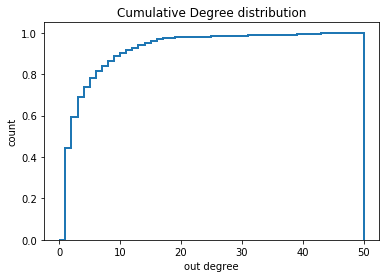

In [34]:
hist_cum = plt.hist(degree_sequence, bins=50, density=True, linewidth=2, 
         histtype='step', cumulative=True, range=(0,50))
plt.title("Cumulative Degree distribution")
plt.xlabel('out degree')
plt.ylabel('count')
plt.show()

In log-log scale:

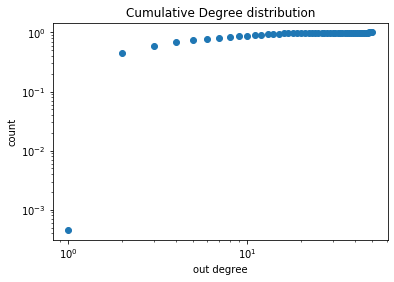

In [35]:
plt.plot(hist_cum[1][1:],hist_cum[0], 'o')
plt.xscale('log')
plt.yscale('log')
plt.title("Cumulative Degree distribution")
plt.xlabel('out degree')
plt.ylabel('count')
plt.show()

If we model this behaviour as a power law, we know that the cdf is:

$$
F(k) = 1 - k^{- \gamma + 1}
$$

Knowing this, we calculate the power scale $\gamma$ and compare it with the one we saw before.

In [36]:
coef = np.polyfit(np.log10(hist_cum[1][1:26]),np.log10(1-hist_cum[0][:25]),1)
poly1d_fn = np.poly1d(coef) 

print('Slope of linear fit: ', coef[0] -1 )

Slope of linear fit:  -2.381011850829909


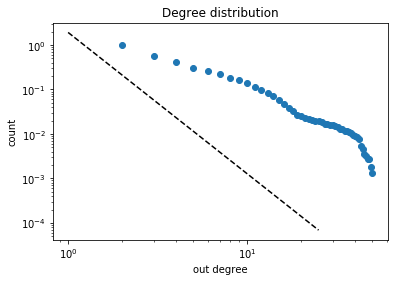

In [37]:
plt.plot(hist_cum[1][2:],1 - hist_cum[0][:-1], 'o')
plt.plot(hist_cum[1][1:26], np.power(10,poly1d_fn(np.log(hist_cum[1][1:26]))), '--k')
plt.xscale('log')
plt.yscale('log')
plt.title("Degree distribution")
plt.xlabel('out degree')
plt.ylabel('count')
plt.show()

With this method we also obtain a slope degree of around -2.3. We conclude that the network degree follows a power law probability distribution. 

## 4. Robustness

Let us begin by defining some notation by following the paper "Attack Robustness and Centrality of Complex Networks" that was introduced on the slides. Let $G$ be a graph and $N$ the total number of nodes. Let $N_\rho$ be the network that results from removing a fraction $\rho$ of the vertices according to some specified procedure. We will denote by $N_\rho '$ the largest component of $N_\rho$. Then, we define
$$
\sigma(\rho) = \frac{|N_\rho '|}{N},
$$
where |$N_\rho '$| is the number of nodes of the network $N_\rho '$. 

The robustness of a network may be measured by how $\sigma(\rho)$ varies as $\rho$ increases. In other words, it is measured by how the fractional size of its largest component varies when some fraction of the nodes are removed. The robustness of a network under this type of vertex removal can be quantified by the R-index, which is defined as follows
$$
R=\frac{1}{N}\sum_{i=1}^N\sigma(i/N).
$$
Then, we define the V-index, which measures the vulnerability of a network to a given scheme of vertex removal, to be the complementary quantity to R
$$
V = \frac{1}{2}-R.
$$

Notice that, so far, we have been assuming that the vertices are removed according to some specified procedure. The removal methods that we are going to consider are the following:
* **degree**: remove vertices according to their degrees, from highest to lowest.
* **random**: remove vertices randomly by following a uniform distribution.

In addition, we are going to use the centralities studied in the former notebook:
* **closeness**: remove vertices according to their values of closeness centrality, from highest to lowest.
* **betweenness**: remove vertices according to their values of betweeness centrality, from highest to lowest.
* **eigenvector**: remove vertices according to their values of eigenvector centrality, from highest to lowest.
* **page-rank**: remove vertices according to their values of page-rank centrality, from highest to lowest.
* **katz**: remove vertices according to their values of katz centrality, from highest to lowest.
* **clustering**: remove vertices according to their values of average clustering coefficient, from highest to lowest.

Let us now plot $\sigma(\rho)$ of our network by using the above removal procedures.

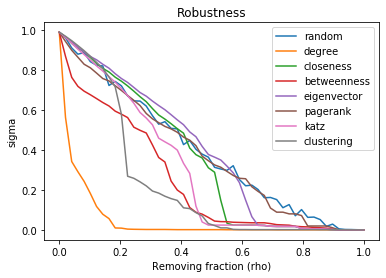

In [38]:
def random_nodes(gr):
    vals = np.random.permutation(len(gr.nodes))
    d = dict()

    for i in range(len(vals)):
        d[i] = vals[i]
    return d


removal_procedures = {'random': random_nodes,
                      'degree': lambda gr: dict(nx.degree(gr)), 
                      'closeness': nx.closeness_centrality,
                      'betweenness':  nx.betweenness_centrality,
                      'eigenvector': nx.eigenvector_centrality, 
                      'pagerank': nx.pagerank, 
                      'katz': nx.katz_centrality,
                      'clustering': nx.clustering}


    
ro_list = list(np.linspace(0.0, 1.0, num=50))
sigma = []
i = 0

for procedure in removal_procedures.keys():    
    for ro in ro_list:
        G_aux = G.copy()
        G_aux.remove_nodes_from(list(nx.isolates(G_aux))) #remove nodes that do not have in nor out neighbors
        N = G_aux.number_of_nodes() #total number of nodes

        #Remove the fraction ro
        centrality = removal_procedures[procedure](G_aux)
        idx = np.argsort(list(centrality.values()))[::-1][:]
        nodes = list(centrality.keys())
        nodes_to_remove = [nodes[i] for i in idx][:int(ro*G_aux.number_of_nodes())]
        G_aux.remove_nodes_from(list(nodes_to_remove))

        #Take the largest component
        try: 
            largest_cc = max(nx.weakly_connected_components(G_aux), key=len)
            G_aux = G_aux.subgraph(largest_cc)
            #compute sigma
            sigma.append(G_aux.number_of_nodes()/N)
        except ValueError:
            sigma.append(0)
        
    #plot
    plt.plot(ro_list, sigma[i*50:(i+1)*50], label=procedure)
    plt.title("Robustness")
    plt.xlabel('Removing fraction (rho)')
    plt.ylabel('sigma')
    i += 1
plt.legend()
plt.show()

We can see that our network is more susceptible to the type of removal that targets the highest degree vertices. Such large-degree vertices (also called *hubs*), are the ones which give structure to the network. We have seen in the previous section that such nodes make the probability distribution of the degree heavy-tailed, so that the decreasing of the degree distribution follows a power law. Therefore, removing those large-degree nodes changes such probabiliy distribution, and therefore the structure of the network.  On the other hand, its highest robustness is achieved by regarding the page-rank centrality removal. We also observe that the network is very robust when removing the nodes randomly.

## 5. Correlations

The correlation between two nodes measure at which extent the degrees of the two nodes are related. Correlation can be computed in two different ways.

(i) **Assortativity Degree**: given a network, it measures at which extent the degree of a node is linearly related to its neighbors' degree. It takes values in the range [-1,1]. A coefficient of 1 stands for a total positive linear correlation, 0 is no linear correlation, and −1 is total negative linear correlation. It is computed as follows
$$
r = \frac{\langle k_ik_j \rangle-\langle k\rangle^2}{\langle k^2 \rangle-\langle k\rangle^2},
$$
where $\langle k\rangle$ is the average degree of the network, $\langle k^2\rangle$ is the average of the squared degree of the network and $\langle k_ik_j\rangle$ is the average of the product of the degrees of all pairs of neighboring nodes.

(ii) **Average Neighbor Degree**: given a node $i$, it is the average of its neighbor's degree. It is computed as follows
$$
k_{nn,i}=\frac{1}{|N(i)|}\sum_{j\in N(i)}k_j,
$$
where $|N(i)|$ is the number of nodes neighbouring $i$ and $k_j$ is the degree of node $j$. 

We distinguish three different types of networks depending on the values of $r$ and the behavior of the plot $k$-$k_{nn}$:
* Assortative: the plot displays an increasing tendency. It happens when the assortativity degree is positive.
* Disassortative: the plot displays a dencreasing tendency. It happens when the assortativity degree is negative.
* No structure: the plot does not display any particular structure. It happens when the assortativity degree is 0.


**Let us begin by computing the assortativity degree.**

In [39]:
print('Degree assortativity of the graph:', nx.degree_assortativity_coefficient(G))

Degree assortativity of the graph: -0.010965433440751684


There is another equivalent function to compute it, called *degree_pearson_correlation_coefficient*, that uses the potentially faster *scipy.stats.pearson* r function.

In [40]:
print('Degree assortativity of the graph by means of the pearson r function:', nx.degree_pearson_correlation_coefficient(G))

Degree assortativity of the graph by means of the pearson r function: -0.010965433440751668


Since the correlation coefficient is quite close to 0, we can assert that there is no linear correlation between both degrees.

**Let us now compute the average neighbor degree.**

We expect a relation given by 
$$
k_{nn}(k)\sim k^{-\nu}.
$$

In [41]:
AvNeigDegree = nx.average_neighbor_degree(G)
Degree = dict(G.degree)

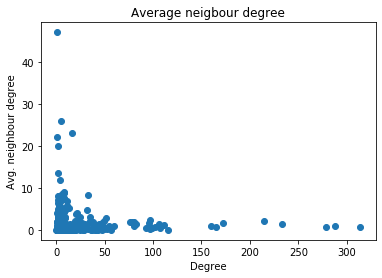

In [42]:
plt.plot(list(Degree.values()), list(AvNeigDegree.values()), 'o')
plt.title('Average neigbour degree')
plt.xlabel('Degree')
plt.ylabel('Avg. neighbour degree')
plt.show()

Equivalently, by taking logarithms, we expect a relation given by
$$
\log(k_{nn}(k))\sim -\nu \log(k).
$$

Let us now plot it taking logarithms and perform a linear regression. Since the assortativity degree was -0.01, we expect our network not to be assortative nor disassortative. That is, we do not expect a linear relation between $k$ and $k_{nn}$. Therefore, $\nu$ should be close to 0.

In [43]:
import sklearn
from sklearn.linear_model import LinearRegression

In [44]:
x = []
for i in list(Degree.values()):
    if i != 0:
        x.append(np.log10(i))
    else:
        x.append(0)
        
y = []
for i in list(AvNeigDegree.values()):
    if i != 0:
        y.append(np.log10(i))
    else:
        y.append(0)
        
x = np.array(x).reshape(-1,1)
y = np.array(y).reshape(-1,1)

In [45]:
Linreg = LinearRegression().fit(x, y)

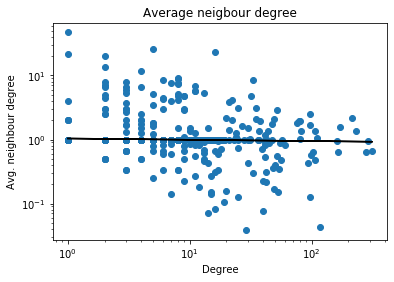

In [46]:
plt.plot(10**x, 10**y, 'o')
plt.plot(10**x, 10**Linreg.predict(x),color='k')
plt.title('Average neigbour degree')
plt.xlabel('Degree')
plt.ylabel('Avg. neighbour degree')
plt.xscale('log')
plt.yscale('log')
plt.show()

In [80]:
print("The slope of the fitting line is {}".format(Linreg.coef_[0][0]))

The slope of the fitting line is -0.006798579298801918


As expected, the above plot does not display any type of structure. In other words, there is no linear correlation between $k$ and $k_{nn}$. In particular, the slope of the fitting line is $\nu\sim 0.006$.